In [152]:


import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix


def equalize_class_size(Data_in):
    Data=Data_in.copy()
    class_num=np.min(Data[Data.shape[1]-1].value_counts())
    classes=(Data[Data.shape[1]-1].value_counts().index)

    frames=[]
    for i in classes:
        Data2=Data.copy()
        filter = Data2[Data2.shape[1]-1]==i
        Data2.where(filter , inplace=True)
        Data2=Data2.dropna()
        Data2=Data2.sample(n=class_num,replace=False,random_state=0)
        frames.append(Data2)
    Data=pd.concat(frames)
    return Data




try: os.mkdir('results')
except: pass

def make_train_test_Data(features,label,pca_num,train_ratio):
    Data=pd.DataFrame(np.concatenate([features,label],axis=1))
    x =  Data.loc[:,[i for i in range(features.shape[1])]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    # PCA
    pca = PCA(n_components=pca_num)
    principalComponents = pca.fit_transform(x)
    Data=pd.DataFrame(np.concatenate([principalComponents,label],axis=1))
    # make train_test
    train=Data.sample(frac=train_ratio,replace=False,random_state=0)
    test=Data.drop(train.index)
    return [train,test]

def train_SVM(train, test):
    x_train =  train.loc[:,[i for i in range(train.shape[1]-1)]].values
    y_train = train.loc[:,[train.shape[1]-1]].values.ravel()

    x_test=  test.loc[:,[i for i in range(test.shape[1]-1)]].values
    y_test = test.loc[:,[test.shape[1]-1]].values.ravel()

    clf = svm.SVC(kernel='rbf',decision_function_shape='ovo'  , class_weight='balanced'  ,max_iter=-1)
    clf.fit(x_train, y_train)

    ####### ACC on Test  ########
    label_predict_Test=[]
    for row in x_test:
        ll=clf.predict([row])
        label_predict_Test.append(ll)

    label_predict_Test=np.array(label_predict_Test)
    label_predict_Test=label_predict_Test.reshape(y_test.shape)
    diff=(label_predict_Test==y_test)
    acc=100*np.sum(diff)/len(y_test) 
    CM=confusion_matrix(y_test, label_predict_Test)
    return [CM,acc]

def plot_CM(CM_in,name,is_save):
    CM=CM_in.copy()
    CM=CM/CM.sum(axis=1)[:,None]
    (a,a)=CM.shape
    ###### save confussion matrix as an image #####
    fig=plt.figure(figsize=(16, 14))
    plt.imshow(CM,  cmap=plt.cm.Blues);
    thresh=CM.max()/2
    for i in range(a):
        for j in range(a):
            number=CM[i, j].copy()
            if number==float(0):
                number=int(number)
            number=round(number,3)
            if(CM[i, j] > thresh) : color="white"
            else: color="black"
            fontweight='normal'
            fontsize=20
            if float(number)>0.5 : 
                fontsize=22
            plt.text(j, i,number ,horizontalalignment="center",color=color,fontsize=fontsize)
    plt.xticks(np.arange(a), labels_name,fontsize='x-large',rotation=-30,fontweight='bold')
    plt.yticks(np.arange(a),  labels_name,fontsize='x-large',fontweight='bold')
    plt.title(name,fontsize=20,fontweight='bold'); plt.ylabel('True label',fontsize=20); plt.xlabel('Predicted label',fontsize=20);
    if is_save:
        fig.savefig('results/'+name+'.jpg', dpi=3*fig.dpi)
        plt.close(fig)




def statistics_CM(CM_in):
    cm=CM_in.copy()
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP

    num_classes = len(labels_name)
    TN = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))

    acc=TP/np.sum(cm, axis=1)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    specificity = TN/(TN+FP)
    F1_score=2*precision*recall/(precision+recall)

    acc=np.append(acc,np.average(acc,weights=np.sum(CM_in,axis=1)/np.sum(CM_in)))
    precision=np.append(precision,np.average(precision,weights=np.sum(CM_in,axis=1)/np.sum(CM_in)))
    recall = np.append(recall,np.average(recall,weights=np.sum(CM_in,axis=1)/np.sum(CM_in)))
    specificity=np.append(specificity,np.average(specificity,weights=np.sum(CM_in,axis=1)/np.sum(CM_in)))
    F1_score=np.append(F1_score,np.average(F1_score,weights=np.sum(CM_in,axis=1)/np.sum(CM_in)))


    df=pd.DataFrame(
        {"Accuracy":np.round(100*acc,2),
        "Recall":np.round(100*recall,2),
        "Precision":np.round(100*precision,2),
        "Specificity":np.round(100*specificity,2),
        "F1-score":np.round(100*F1_score,2)})
    tmp=dict((v-1,k) for k,v in labels_dict.items())
    tmp[5]='All classes'
    return df.rename(index=tmp)


#*******************************************************************
#************************** Prepare Data ***************************
#*******************************************************************


######## labels name ##########
labels_name=os.listdir('Implementation/features/Train_ILD')
try: labels_name.remove('.DS_Store')
except: pass
labels_dict={}
for i in range(len(labels_name)):
    labels_dict[labels_name[i]]=i+1

######## ILD ##########
label_ILD=[]
features_ILD=[]

for ll in labels_name:
    label_path=os.path.join('Implementation/features/Train_ILD',ll)
    files=os.listdir(label_path)
    try: files.remove('.DS_Store')
    except: pass
    for row in files:
        file_path=os.path.join(label_path,row)
        feature_vector = scipy.io.loadmat(file_path)['feature_vector']
        features_ILD.append(feature_vector[0])

    label_ILD+=[labels_dict[ll]]*len(files)

features_ILD=np.array(features_ILD)
label_ILD=np.array(label_ILD)
label_ILD = np.reshape(label_ILD,(features_ILD.shape[0],1))



######## Talisman ##########
label_Talisman=[]
features_Talisman=[]

for ll in labels_name:
    label_path=os.path.join('Implementation/features/Test_Talisman',ll)
    files=os.listdir(label_path)
    try: files.remove('.DS_Store')
    except: pass
    for row in files:
        file_path=os.path.join(label_path,row)
        feature_vector = scipy.io.loadmat(file_path)['feature_vector']
        features_Talisman.append(feature_vector[0])

    label_Talisman+=[labels_dict[ll]]*len(files)

features_Talisman=np.array(features_Talisman)
label_Talisman=np.array(label_Talisman)
label_Talisman = np.reshape(label_Talisman,(features_Talisman.shape[0],1))




Epoch 1/100
601/601 [==============================] - 1s 728us/step - loss: 0.9200 - accuracy: 0.6690 - val_loss: 0.6453 - val_accuracy: 0.7748
Epoch 2/100
601/601 [==============================] - 0s 618us/step - loss: 0.7003 - accuracy: 0.7530 - val_loss: 0.5936 - val_accuracy: 0.7861
Epoch 3/100
601/601 [==============================] - 0s 600us/step - loss: 0.6550 - accuracy: 0.7688 - val_loss: 0.5680 - val_accuracy: 0.7950
Epoch 4/100
601/601 [==============================] - 0s 597us/step - loss: 0.6269 - accuracy: 0.7799 - val_loss: 0.5535 - val_accuracy: 0.8001
Epoch 5/100
601/601 [==============================] - 0s 761us/step - loss: 0.6056 - accuracy: 0.7853 - val_loss: 0.5455 - val_accuracy: 0.8030
Epoch 6/100
601/601 [==============================] - 0s 671us/step - loss: 0.5925 - accuracy: 0.7903 - val_loss: 0.5397 - val_accuracy: 0.8035
Epoch 7/100
601/601 [==============================] - 0s 592us/step - loss: 0.5887 - accuracy: 0.7887 - val_loss: 0.5294 - val_ac

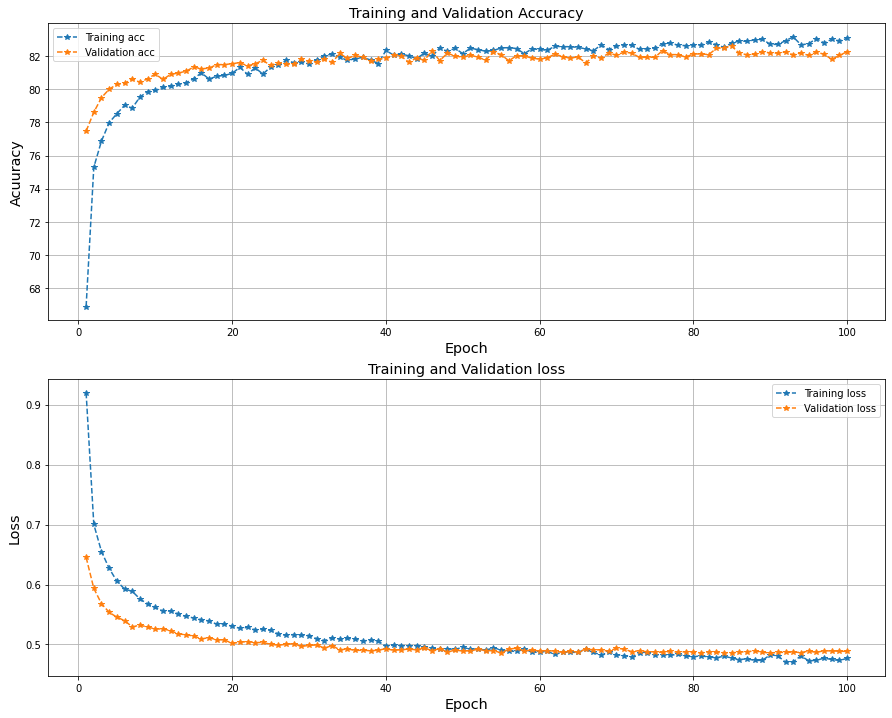

In [178]:




import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models, layers 
import tensorflow as tf

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def my_convert(arr_in):
    tmp=np.zeros((arr_in.shape[0],5))
    for i,row in enumerate(arr_in):
        tmp[i][int(row)-1]=1 
    return tmp.copy()




######## labels name ##########
labels_name=os.listdir('Implementation/features/Train_ILD')
try: labels_name.remove('.DS_Store')
except: pass
labels_dict={}
for i in range(len(labels_name)):
    labels_dict[labels_name[i]]=i+1

######## ILD ##########
label_ILD=[]
features_ILD=[]

for ll in labels_name:
    label_path=os.path.join('Implementation/features/Train_ILD',ll)
    files=os.listdir(label_path)
    try: files.remove('.DS_Store')
    except: pass
    for row in files:
        file_path=os.path.join(label_path,row)
        feature_vector = scipy.io.loadmat(file_path)['feature_vector']
        features_ILD.append(feature_vector[0])

    label_ILD+=[labels_dict[ll]]*len(files)

features_ILD=np.array(features_ILD)
label_ILD=np.array(label_ILD)
label_ILD = np.reshape(label_ILD,(features_ILD.shape[0],1))



# ***** PCA *********
Data=pd.DataFrame(np.concatenate([features_ILD,label_ILD],axis=1))
x =  Data.loc[:,[i for i in range(features_ILD.shape[1])]].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(x)
Data=pd.DataFrame(np.concatenate([principalComponents,label_ILD],axis=1))



# ***** Prepare Data *********
Train1=Data.groupby(Data.shape[1]-1).apply(lambda s: s.sample(frac=0.9,replace=False,random_state=0))
Train1 = Train1.reset_index(level=[None])
Train1=Train1.set_index('level_1')
Test= Data.drop(index=Train1.index)
Train=Train1.groupby(Data.shape[1]-1).apply(lambda s: s.sample(frac=0.72,replace=False,random_state=0))
Train = Train.reset_index(level=['level_1'])
Train=Train.set_index('level_1')
Validation= Train1.drop(index=Train.index)


x_train =  Train.loc[:,[i for i in range(Train.shape[1]-1)]].values
y_train = Train.loc[:,[Train.shape[1]-1]].values.ravel()
x_train, y_train=unison_shuffled_copies(x_train, y_train)

x_test =  Test.loc[:,[i for i in range(Test.shape[1]-1)]].values
y_test = Test.loc[:,[Test.shape[1]-1]].values.ravel()
x_test, y_test=unison_shuffled_copies(x_test, y_test)

x_val =  Validation.loc[:,[i for i in range(Validation.shape[1]-1)]].values
y_val = Validation.loc[:,[Validation.shape[1]-1]].values.ravel()
x_val, y_val=unison_shuffled_copies(x_val, y_val)


# ********** Train neural network  **********
epochs_num=60
with tf.device('/CPU:0'):
    ### layer input
    inputs = layers.Input(x_train.shape[1:])
    ### hidden layers
    hidden1 = layers.Dense(80,name="hidden1",activation='relu')(inputs)
    drop1=layers.Dropout(0.4)(hidden1)
    hidden2 = layers.Dense(80,name="hidden2", activation='relu')(drop1)
    drop2=layers.Dropout(0.4)(hidden2)
    hidden3 = layers.Dense(20,name="hidden3", activation='relu')(drop2)
    ### layer output
    outputs = layers.Dense(5,name="output", activation='softmax')(hidden3)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, my_convert(y_train), validation_data=(x_val,my_convert(y_val)),epochs=epochs_num, verbose=1)

    Test_loss, Test_acc = model.evaluate(x_test, my_convert(y_test), verbose=1)
    print('\nTest loss:',str(round(Test_loss,5)))
    print('Test Accuracy:',str(round(100*Test_acc,4)),' %\n')



fig=plt.figure(figsize=(15,12))
plt.subplot(211)
plt.plot(range(1, epochs_num+1), np.array(history.history['accuracy'])*100, '*--', label='Training acc')
plt.plot(range(1, epochs_num+1), np.array(history.history['val_accuracy'])*100, '*--', label='Validation acc')
plt.title('Training and Validation Accuracy',fontsize='x-large'); 
plt.legend();plt.grid();plt.xlabel("Epoch",fontsize='x-large'); plt.ylabel("Acuuracy",fontsize='x-large')
plt.subplot(212)
plt.plot(range(1, epochs_num+1), history.history['loss'], '*--', label='Training loss')
plt.plot(range(1, epochs_num+1), history.history['val_loss'], '*--', label='Validation loss')
plt.title('Training and Validation loss',fontsize='x-large')
plt.grid();plt.xlabel("Epoch",fontsize='x-large'); plt.ylabel("Loss",fontsize='x-large'); plt.legend()
plt.show()
fig.savefig('results/NN_train.jpg', dpi=3*fig.dpi)



In [192]:
import visualkeras





inputs = layers.Input(x_train.shape[1:])
### hidden layers
hidden1 = layers.Dense(80,name="hidden1",activation='relu')(inputs)
drop1=layers.Dropout(0.4)(hidden1)
hidden2 = layers.Dense(80,name="hidden2", activation='relu')(drop1)
drop2=layers.Dropout(0.4)(hidden2)
hidden3 = layers.Dense(15,name="hidden3", activation='relu')(drop2)
### layer output
outputs = layers.Dense(5,name="output", activation='softmax')(hidden3)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

********


In [9]:
import numpy as np



scores=np.array([
    [87.6, 3.9, 1.9, 0.4, 6.1],
    [12.4 ,80.6 ,0.4 ,4.9 ,1.7],
    [3.5, 0.2 ,82.7, 10.5 ,3.1],
    [3.3, 4.0 ,9.3, 81.2 ,2.2],
    [12.3 ,0.5 ,4.3 ,1.8, 81.1]])

tmp=[6934,1474,2974,4456,7893]

acc=0
for i in range(5):
    acc+=scores[i,i]*tmp[i]

acc/np.sum(tmp)

83.18748051072437

In [1]:
import torch


*************


In [95]:
# '''
# from sklearn.neighbors import KNeighborsClassifier


# for jj in range(8,35):



#     [ILD_train,ILD_test]=make_train_test_Data(features_ILD,label_ILD,jj,ratio)

#     train=ILD_train.copy()
#     test=ILD_test.copy()

#     x_train =  train.loc[:,[i for i in range(train.shape[1]-1)]].values
#     y_train = train.loc[:,[train.shape[1]-1]].values.ravel()

#     x_test=  test.loc[:,[i for i in range(test.shape[1]-1)]].values
#     y_test = test.loc[:,[test.shape[1]-1]].values.ravel()



#     for ii in range(3,10):

#         neigh = KNeighborsClassifier(n_neighbors=ii)
#         neigh.fit(x_train, y_train)



#         ####### ACC on Test  ########
#         label_predict_Test=[]
#         for row in x_test:
#             ll=neigh.predict([row])
            
#             label_predict_Test.append(ll)

#         label_predict_Test=np.array(label_predict_Test)
#         label_predict_Test=label_predict_Test.reshape(y_test.shape)
#         diff=(label_predict_Test==y_test)
#         acc=100*np.sum(diff)/len(y_test) 
#         # CM=confusion_matrix(y_test, label_predict_Test)
        

#         print('pca:',jj,'KNN',ii,' , ',acc)





# from sklearn.ensemble import RandomForestClassifier




# for ii in range(3,20):

#     clf = RandomForestClassifier(max_depth=ii, random_state=0)

#     clf.fit(x_train, y_train)



#     ####### ACC on Test  ########
#     label_predict_Test=[]
#     for row in x_test:
#         ll=clf.predict([row])
#         label_predict_Test.append(ll)

#     label_predict_Test=np.array(label_predict_Test)
#     label_predict_Test=label_predict_Test.reshape(y_test.shape)
#     diff=(label_predict_Test==y_test)
#     acc=100*np.sum(diff)/len(y_test) 
#     # CM=confusion_matrix(y_test, label_predict_Test)
    

#     print(ii,' , ',acc)

# '''

In [96]:
# import pycm


# train=ILD_train.copy()
# test=ILD_test.copy()

# x_train =  train.loc[:,[i for i in range(train.shape[1]-1)]].values
# y_train = train.loc[:,[train.shape[1]-1]].values.ravel()

# x_test=  test.loc[:,[i for i in range(test.shape[1]-1)]].values
# y_test = test.loc[:,[test.shape[1]-1]].values.ravel()

# clf = svm.SVC(kernel='rbf',decision_function_shape='ovo'  , class_weight='balanced'  ,max_iter=-1)
# clf.fit(x_train, y_train)

# ####### ACC on Test  ########
# label_predict_Test=[]
# for row in x_test:
#     ll=clf.predict([row])
#     label_predict_Test.append(ll)

# label_predict_Test=np.array(label_predict_Test)
# label_predict_Test=label_predict_Test.reshape(y_test.shape)


# cm = pycm.ConfusionMatrix(label_predict_Test,y_test,digit=6)


In [97]:
# tp=sum(cm.TP.values())
# fp=sum(cm.FP.values())
# fn=sum(cm.FN.values())

# precision = tp / (tp+fp)
# recall = tp / (tp+fn)
# F1=(2*precision*recall)/(precision+recall)
# acc=1-(fn+fp)/270
# print(' Precision: {}\n Recall: {}\n F1-score : {}\n accuracy : {}'.format(precision, recall,F1,acc))


In [98]:
# from operator import truediv
# import numpy as np

# tp = np.diag(CM_ILD)
# prec = list(map(truediv, tp, np.sum(CM_ILD, axis=0)))
# rec = list(map(truediv, tp, np.sum(CM_ILD, axis=1)))
# print ('Precision: {}\nRecall: {}'.format(prec, rec))

In [99]:



# df = pd.DataFrame(CM_ILD.T)#,index= lables_name, columns=lables_name)


# df_stat=round(df.da.export_metrics()*100,2)
# df_stat.drop(['false_discovery_rate','negative_predictive_value',
#                 'positive_predictive_value','false_negative_rate',
#                 'false_positive_rate','true_negative_rate','true_positive_rate'])

In [100]:

# import numpy as np
# import cv2
# import os
# import matplotlib.pyplot as plt
# import scipy.io
# import scipy.stats as stats


# def plot_estimate(data,title,shape_param,gamma):
    
#     plt.plot(np.sort(data), stats.weibull_min.pdf(np.sort(data), *stats.weibull_min.fit(np.sort(data), floc=0)), linewidth=1)
#     weibull_pdf=stats.weibull_min.pdf(data, *stats.weibull_min.fit(data, floc=0))
#     (markerline, stemlines, baseline)  =plt.stem(data, weibull_pdf)
#     plt.setp(markerline, marker='.', markersize=1, markeredgecolor="blue", markeredgewidth=1.5)
#     plt.setp(stemlines,linestyle=':',linewidth=0.05)


#     _ = plt.hist(data, alpha=0.6,ec='black',histtype='bar',rwidth=0.95);
#     plt.yticks([], []); plt.xticks([], []);
#     plt.annotate('K: '+str(shape_param)+'\ngamma: '+str(gamma),xy=(320, 150), xycoords='axes points',size=11, ha='right', va='top')
#     plt.title(title)

# step=4

# for level in range(1,3):
#     filename='wavelet_mat/Train_ILD/emphysema/17_slice_7_emphysema_non-relevant_1_1_level%d.mat'%level    
#     mat = scipy.io.loadmat(filename)['wavelet_level_sq']
#     for idx in range(4):
#         matrix=mat[::,::,idx]
#         matrix=matrix-np.amin(matrix)


#         [m,n]=matrix.shape
#         [F1,F2,F3]=[[],[],[]]
#         for i in range(0,m-step+1):
#             for j in range(0,n-step+1):
#                 window=matrix[i:i+step,j:j+step]
#                 singularValue=np.linalg.svd(window, compute_uv=False)
#                 F1.append(np.max(singularValue))
#                 F2.append(np.mean(singularValue))
#                 F3.append(np.median(singularValue))

#         [shape_param1, _ , gamma1]=stats.weibull_min.fit(F1,floc=0)
#         [shape_param2, _ , gamma2]=stats.weibull_min.fit(F2,floc=0)
#         [shape_param3, _ , gamma3]=stats.weibull_min.fit(F3,floc=0)

#         plt.figure(figsize=(15,3))
#         plt.subplot(131);plot_estimate(F1,'F1 WeiBull estimate, subband %d, Level %d'%((idx+1),level),round(shape_param1,4),round(gamma1,5))
#         plt.subplot(132);plot_estimate(F2,'F2 WeiBull estimate, subband %d, Level %d'%((idx+1),level),round(shape_param2,4),round(gamma2,5))
#         plt.subplot(133);plot_estimate(F3,'F3 WeiBull estimate, subband %d, Level %d'%((idx+1),level),round(shape_param3,4),round(gamma3,5))
#         plt.show()
